# SYDE 556/750 --- Assignment 1
**Student ID: 20883350**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_01/syde556_assignment_01.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt # For question 2.1b)
import seaborn as sns
from matplotlib import cm
sns.set_style("darkgrid")

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Representation of Scalars

## 1.1 Basic encoding and decoding

**a) Computing gain and bias.** In general, for a neuron model $a = G[J]$ (and assuming that the inverse $J = G^{-1}[a]$ exists), solve the following system of equations to compute the gain $\alpha$, and the bias $J^\mathrm{bias}$ given a maximum rate $a^\mathrm{max}$ and an $x$-intercept $\xi$.

$$a^\mathrm{max} = G[\alpha + J^\mathrm{bias}] \,, \quad\quad 0 = G[\alpha \xi + J^\mathrm{bias}] \,.$$

![Q1.1 Rough Work](./screenshots/1_1_a_work.PNG)

We have
1. alpha = ($G^{-1}[amax]$ - J_th) / ( 1 - zeta )
2. J_bias = (J_th - $G^{-1}[amax]$ * zeta) / (1 - zeta)

Now, simplify these equations for the specific case $G[J] = \max(J, 0)$.

![Q1.1 Rough Work](./screenshotS/1_1_a_relu.PNG)

This simplifies to...
1. alpha = (a_max) / ( 1 - zeta )
2. J_bias = (- a_max * zeta) / (1 - zeta)

**b) Neuron tuning curves.** Plot the neuron tuning curves $a_i(x)$ for 16 randomly generated neurons following the intercept and maximum rate distributions described above.

In [2]:
# note: The code below is for more than just Q1(b).
# I wrote a neuron interface class, and kept changing it as more questions arose
# these are the final neuron classes I came up with (and has code for more than just this section)

class Neuron:
    def __init__(self, a_max_range, zeta_range):
        self.a_max = np.random.uniform(*a_max_range)
        # note: zeta is already a computed dot product; it works in any dimension
        self.zeta = np.random.uniform(*zeta_range)
        self.e = self.compute_e()

        self.alpha = self.compute_alpha()
        self.J_bias = self.compute_J_bias()
        
    
    def x_to_J(self, x_samples):
        # input variable to current
        return self.alpha * (np.dot(self.e, x_samples)) + self.J_bias
    
    def compute_J_bias(self):
        pass

    def compute_alpha(self):
        pass

    def compute_e(self):
        pass
    
    def compute_tuning_curve(self, x_samples):
        pass


class ReluNeuron(Neuron):
    def compute_e(self):
        return np.random.choice([-1, 1])
    def compute_J_bias(self):
        return (-self.a_max * self.zeta) / (1 - self.zeta)
    def compute_alpha(self):
        return self.a_max / (1 - self.zeta)
    def compute_tuning_curve(self, x_samples):
        return np.maximum(self.x_to_J(x_samples), np.zeros(x_samples.shape[0]))


class LIFNeuron1D(Neuron):
    def __init__(self, a_max_range, zeta_range, tau_ref_ms, tau_rc_ms):
        self.tau_ref_s = tau_ref_ms / 1000
        self.tau_rc_s = tau_rc_ms / 1000
        super().__init__(a_max_range, zeta_range)

    def compute_e(self):
        return np.random.choice([-1, 1])
    def compute_J_bias(self):
        # assume alpha exists
        return 1 - self.alpha * self.zeta


    def compute_alpha(self):
        # no J_bias assumption
        return ((1 / (1 - np.exp((self.tau_ref_s - (1/self.a_max)) / self.tau_rc_s))) - 1) / (1 - self.zeta)
    
    
    def compute_tuning_curve(self, x_samples):
        J = self.x_to_J(x_samples)
        J_safe = np.where(J > 1, J, np.nan)  # Replace invalid J values with NaN
        return np.where(J > 1, 1 / (self.tau_ref_s - self.tau_rc_s * np.log(1 - (1 / J_safe))), 0)


class LIFNeuron2D(LIFNeuron1D):
    def __init__(self, a_max_range, zeta_range, tau_ref_ms, tau_rc_ms, angle):
        self.preffered_dir = angle
        super().__init__(a_max_range, zeta_range, tau_ref_ms, tau_rc_ms)
    
    def compute_e(self):
        # compute the encoder in 2D based on preferred direction
        enc_x = np.cos(self.preffered_dir)
        enc_y = np.sin(self.preffered_dir)
        return np.array([enc_x, enc_y])


In [3]:
# this is a factory function to be able to create ant type of neuron from a common functon
def create_neuron(type, a_max_range = [100, 200], zeta_range = [-0.95, 0.95], tau_ref_ms = 2, tau_rc_ms = 20, angle = 0):
    if type not in ["relu", "LIF", "LIF2D"]:
        raise TypeError("Neuron type must be relu or LIF")
    
    if type == "relu":
        return ReluNeuron(a_max_range, zeta_range)
    
    if type == "LIF":
        return LIFNeuron1D(a_max_range, zeta_range, tau_ref_ms, tau_rc_ms)
    
    if type == "LIF2D":
        return LIFNeuron2D(a_max_range, zeta_range, tau_ref_ms, tau_rc_ms, angle)

In [4]:
def create_multiple_neuron_tuning_curves(x_samples, n_neurons, neuron_type, angles = None):
    if angles is None:
        angles = np.zeros(n_neurons)
    if angles.shape[0] != n_neurons:
        raise ValueError("There must be an angle provided for every neuron possible")
    tuning_curves = []
    neurons = []
    for angle in angles:
        neuron = create_neuron(neuron_type, angle=angle)
        neurons.append(neuron)
        tuning_curves.append(neuron.compute_tuning_curve(x_samples))
    return tuning_curves, neurons

In [5]:
x_samples = np.linspace(-1, 1, num=41)
x_samples.shape[0]

41

In [6]:
def plot_tuning_curves(x_samples, tuning_curves, title, x_label, y_label):
    for curve in tuning_curves:
        ax = sns.lineplot(x = x_samples, y = curve)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

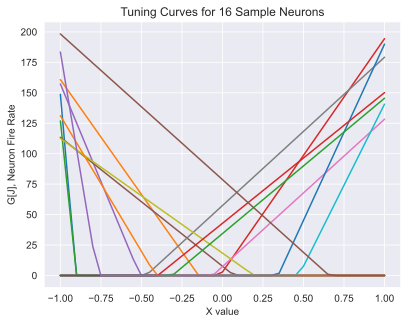

In [7]:
tuning_curves, _ = create_multiple_neuron_tuning_curves(x_samples, 16, "relu")
plot_tuning_curves(x_samples, tuning_curves, "Tuning Curves for 16 Sample Neurons", "X value", "G[J], Neuron Fire Rate")

**c) Computing identity decoders.** Compute the optimal identity decoder $\vec d$ for those 16 neurons (as shown in class). Report the value of the individual decoder coefficients. Compute $d$ using the matrix notation mentioned in the course notes. Do not apply any regularization. $A$ is the matrix of activities (the same data used to generate the plot in 1.1b).

In [8]:
# first create the activity matrix, A
A = np.array([curve for curve in tuning_curves])
A.shape

(16, 41)

In [9]:
# apply the equation to solve for D transpose
D_solve_no_reg = lambda A, x: np.linalg.inv(A @ A.T) @ A @ x.T
D = D_solve_no_reg(A, x_samples).T
D.shape

(16,)

In [10]:
for i, d in enumerate(D):
    print(f"The optimal decoder value for the {i}th neuron is: {d}")

The optimal decoder value for the 0th neuron is: -0.00015296458280422698
The optimal decoder value for the 1th neuron is: -0.001279398441286085
The optimal decoder value for the 2th neuron is: 0.00018960802606932115
The optimal decoder value for the 3th neuron is: 0.0030120068853558193
The optimal decoder value for the 4th neuron is: 0.0009077007323031287
The optimal decoder value for the 5th neuron is: -0.003529702758774022
The optimal decoder value for the 6th neuron is: -0.0007213424559790391
The optimal decoder value for the 7th neuron is: -0.0025988165812348696
The optimal decoder value for the 8th neuron is: -8.707702116650742e-05
The optimal decoder value for the 9th neuron is: 0.0004337591720017962
The optimal decoder value for the 10th neuron is: 9.698043860965205e-05
The optimal decoder value for the 11th neuron is: -0.0023640397231857596
The optimal decoder value for the 12th neuron is: 0.0010089220841108804
The optimal decoder value for the 13th neuron is: 0.004933430950395

**d) Evaluating decoding errors.** Compute and plot $\hat{x}=\sum_i d_i a_i(x)$. Overlay on the plot the line $y=x$. Make a separate plot of $x-\hat{x}$ to see what the error looks like. Report the Root Mean Squared Error (RMSE) value.

In [11]:
# compute the reconstructed X
X_hat = D @ A
X_hat.shape

(41,)

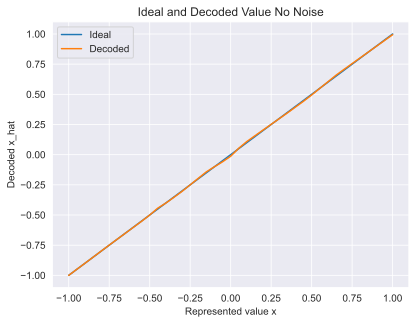

In [12]:
# overlay on plot for y = x
def plot_ideal_and_decoded_values(x, x_hat, title):
    sns.lineplot(x = x, y = x, label="Ideal")
    ax = sns.lineplot(x = x, y = x_hat, label="Decoded")
    plt.legend()
    ax.set_title(title)
    ax.set_xlabel("Represented value x")
    ax.set_ylabel("Decoded x_hat")
plot_ideal_and_decoded_values(x_samples, X_hat, "Ideal and Decoded Value No Noise")

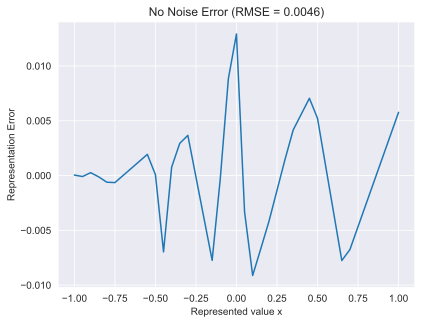

In [13]:
def plot_decoded_error(x, x_hat, title):
    rmse = np.sqrt(np.mean((x - x_hat) ** 2))
    ax = sns.lineplot(x = x, y = x - x_hat)
    ax.set_title(f"{title} (RMSE = {round(rmse, 4)})")
    ax.set_xlabel("Represented value x")
    ax.set_ylabel("Representation Error")
plot_decoded_error(x_samples, X_hat, "No Noise Error")

**e) Decoding under noise.** Now try decoding under noise. Add random normally distributed noise to $a$ and decode again. The noise is a random variable with mean $\mu=0$ and standard deviation of $\sigma=0.2 \max(A)$ (where $\max(A)$ is the maximum firing rate of all the neurons). Resample this variable for every different $x$ value for every different neuron. Create all the same plots as in part d). Report the RMSE.

In [14]:
# create a noise matrix
sigma = 0.2 * np.max(A)
E = np.random.normal(0, sigma, size=A.shape)
E.shape

(16, 41)

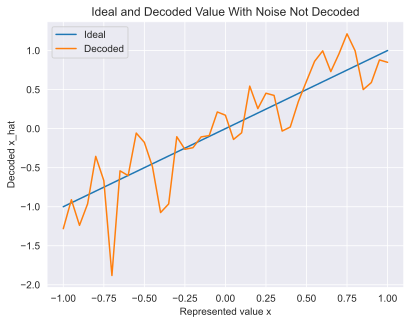

In [15]:
A_noise = A + E

# solve for decoders
# D_no_reg = D_solve_no_reg(A, x_samples).T
# get represention of X back
x_hat_noise_no_reg = D @ A_noise

plot_ideal_and_decoded_values(x_samples, x_hat_noise_no_reg, "Ideal and Decoded Value With Noise Not Decoded")

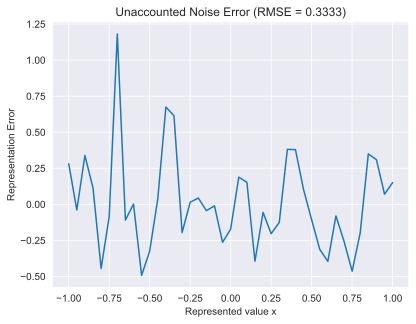

In [16]:
plot_decoded_error(x_samples, x_hat_noise_no_reg, "Unaccounted Noise Error")

**f) Accounting for decoder noise.** Recompute the decoder $\vec d$ taking noise into account (i.e., apply the appropriate regularization, as shown in class). Show how these decoders behave when decoding both with and without noise added to $a$ by making the same plots as in d) and e). Report the RMSE for all cases.

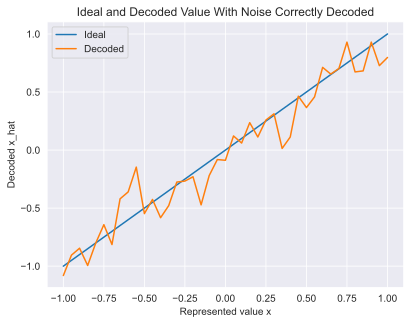

In [17]:
D_solve_reg = lambda A, x, sigma: np.linalg.inv(A @ A.T + len(x) * sigma**2 * np.identity(A.shape[0])) @ A @ x.T

D_reg = D_solve_reg(A, x_samples, sigma)
x_hat_noise_reg = D_reg @ A_noise
plot_ideal_and_decoded_values(x_samples, x_hat_noise_reg, "Ideal and Decoded Value With Noise Correctly Decoded")

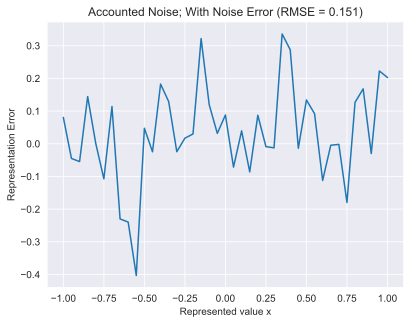

In [18]:
plot_decoded_error(x_samples, x_hat_noise_reg, "Accounted Noise; With Noise Error")

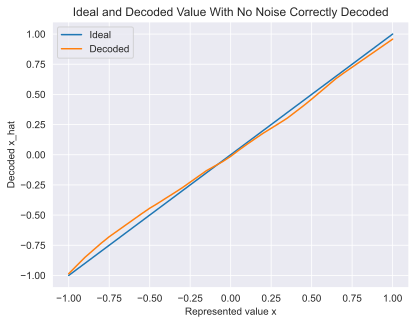

In [19]:
x_hat_no_noise_reg = D_reg @ A
plot_ideal_and_decoded_values(x_samples, x_hat_no_noise_reg, "Ideal and Decoded Value With No Noise Correctly Decoded")

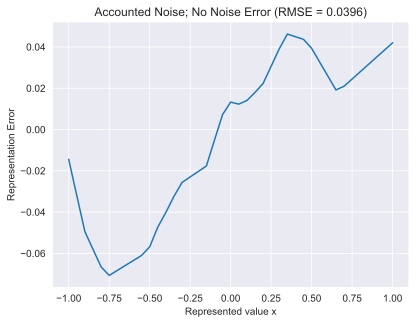

In [20]:
plot_decoded_error(x_samples, x_hat_no_noise_reg, "Accounted Noise; No Noise Error")

**g) Interpretation.** Show a 2x2 table of the four RMSE values reported in parts d), e), and f). This should show the effects of adding noise and whether the decoders $d$ are computed taking noise into account. Write a few sentences commenting on what the table shows, i.e., what the effect of adding noise to the activities is with respect to the measured error and why accounting for noise when computing the decoders increases/decreases/does not change the measured RMSE.

| D Noise Accounted? / A noisy? | Yes  | No   |
|-------------------|------|------|
| **Yes**           | [0.151]  | [0.0396]  |
| **No**            | [0.3333]  | [0.0046]  |

Adding noise to the activities increases the error; when noise was accounted for in the decoder calculation, the RMSE for the activities without noise was 0.0396 and increased to 0.151 when noise was added to activities. The same increase was observed when the decoders did not account for noise, where RMSE went from 0.0046 -> 0.3333, thus adding noise increases error. 

The other observation is that accounting for noise when computing the decoders both increased and decreased the RMSE. For noisy activities, taking noise into account for computing the decoders decreased the RMSE (0.3333 -> 0.151) because L2 normalization was applied to the decoders. This regularization technique penalizes high weights for the noisy activities, which make the decoder weights smaller when accounted for and drives down noise. However, when the activites were not noisy, accounting for noise in the decoders increased the RMSE (opposite effect). This makes sense since the regularization technique will penalize high decoder weights again, but we expect that large weights are ok since no noise has been added so these large weights will be accurate. The regularization reduces the large weights, slightly increasing the error but still yielding quite good results

## 1.2 Exploring sources of error

**a) Exploring error due to distortion and noise.** Plot the error due to distortion $E_\mathrm{dist}$ and the error due to noise $E_\mathrm{noise}$ as a function of $n$, the number of neurons. Generate two different loglog plots (one for each type of error) with $n$ values of at least $[4, 8, 16, 32, 64, 128, 256, 512]$. For each $n$ value, do at least $5$ runs and average the results. For each run, different $\alpha$, $J^\mathrm{bias}$, and $e$ values should be generated for each neuron. Compute $d$ taking noise into account, with $\sigma = 0.1 \max(A)$. Show visually that the errors are proportional to $1/n$ or $1/n^2$.

In [21]:
# take a neuron and run through the process of getting the decoders and decoded values
def compte_all_errors_for_n_neurons(n_neurons, x_samples, sigma_coeff):
    # get activities for some number of generated neurons
    tuning_curves, _ = create_multiple_neuron_tuning_curves(x_samples, n_neurons, "relu")
    A = np.array([curve for curve in tuning_curves])
    sigma = sigma_coeff * np.max(A)
    D_reg = D_solve_reg(A, x_samples, sigma)
    x_hat = D_reg @ A

    # E = np.mean(np.square(x_samples - x_hat))
    # note: in textbook, there's no *1/2 on this term
    E_noise = 0.5 * (sigma**2) * np.sum(np.square(D_reg))
    # E_dist is the MSE
    E_dist = np.mean(np.square(x_samples - x_hat))
    return E_dist, E_noise

In [22]:
def compute_error_for_n_neurons_averaged(n_neurons, x_samples, sigma_coeff, n_runs=5):
    all_E_dist = []
    all_E_noise = []
    for i in range(n_runs):
        E_dist, E_noise = compte_all_errors_for_n_neurons(n_neurons, x_samples, sigma_coeff)
        all_E_dist.append(E_dist)
        all_E_noise.append(E_noise)
        # print(f"Runs {i} had EDist: {E_dist} and ENoise: {E_noise}")

    all_E_dist = np.array(all_E_dist)
    all_E_noise = np.array(all_E_noise)
    return np.mean(all_E_dist), np.mean(all_E_noise)

In [23]:
def compute_error_varying_neuron_amounts(varying_n_neurons, sigma_coeff):
    E_dist_by_n_neurons = []
    E_noise_by_n_neurons = []
    for n_neurons in varying_n_neurons:
        E_dist, E_noise = compute_error_for_n_neurons_averaged(n_neurons, x_samples, sigma_coeff)
        E_dist_by_n_neurons.append(E_dist)
        E_noise_by_n_neurons.append(E_noise)
    E_dist_by_n_neurons = np.array(E_dist_by_n_neurons)
    E_noise_by_n_neurons = np.array(E_noise_by_n_neurons)
    return E_dist_by_n_neurons, E_noise_by_n_neurons


In [24]:
# generate a range of neurons
n_neurons_range = np.array([2**n for n in range(2, 12)])
sigma_coeff_1 = 0.1
E_dist_by_n_neurons, E_noise_by_n_neurons = compute_error_varying_neuron_amounts(n_neurons_range, sigma_coeff_1)

n_neurons_range.shape, E_dist_by_n_neurons.shape, E_noise_by_n_neurons.shape

((10,), (10,), (10,))

In [25]:
E_dist_by_n_neurons, E_noise_by_n_neurons, n_neurons_range

(array([5.85680877e-02, 2.23685622e-03, 3.26720734e-04, 1.20007045e-04,
        2.74671597e-05, 5.48133198e-06, 1.86715462e-06, 5.38175083e-07,
        1.16456823e-07, 3.38631927e-08]),
 array([8.56102935e-03, 5.77802716e-03, 2.95679968e-03, 1.48470540e-03,
        7.18653029e-04, 3.34025596e-04, 1.71693570e-04, 8.61651933e-05,
        4.18089046e-05, 2.07364849e-05]),
 array([   4,    8,   16,   32,   64,  128,  256,  512, 1024, 2048]))

In [26]:
def create_log_log_plot(x_data, y_data, x_label, y_label, title):
    ax = sns.lineplot(x = x_data, y = y_data, label="Error")
    sns.lineplot(x = x_data, y = 1/x_data, label="1/n")
    sns.lineplot(x = x_data, y = 1/(np.square(x_data)), label="1/n^2")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

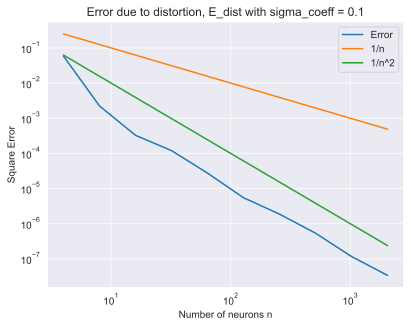

In [27]:
create_log_log_plot(n_neurons_range, E_dist_by_n_neurons, "Number of neurons n", "Square Error", f"Error due to distortion, E_dist with sigma_coeff = {sigma_coeff_1}")

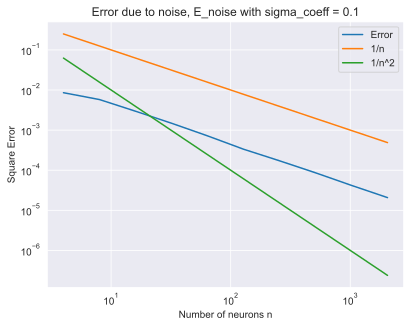

In [28]:
create_log_log_plot(n_neurons_range, E_noise_by_n_neurons, "Number of neurons n", "Square Error", f"Error due to noise, E_noise with sigma_coeff = {sigma_coeff_1}")

**b) Adapting the noise level.** Repeat part a) with $\sigma = 0.01 \max(A)$.

In [29]:
sigma_coeff_2 = 0.01
E_dist_by_n_neurons_2, E_noise_by_n_neurons_2 = compute_error_varying_neuron_amounts(n_neurons_range, sigma_coeff_2)

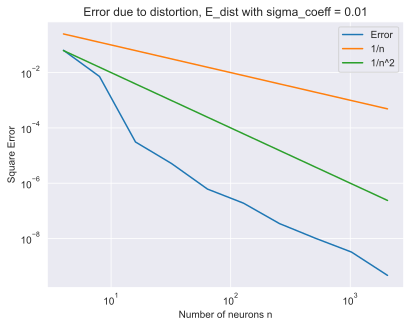

In [30]:
create_log_log_plot(n_neurons_range, E_dist_by_n_neurons_2, "Number of neurons n", "Square Error", f"Error due to distortion, E_dist with sigma_coeff = {sigma_coeff_2}")

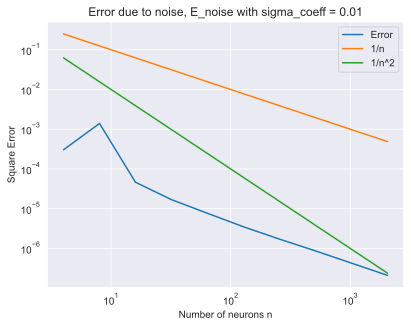

In [31]:
create_log_log_plot(n_neurons_range, E_noise_by_n_neurons_2, "Number of neurons n", "Square Error", f"Error due to noise, E_noise with sigma_coeff = {sigma_coeff_2}")

**c) Interpretation.** What does the difference between the graphs in a) and b) tell us about the sources of error in neural populations?

Both errors (error due to noise and do to distortion) are reduced as sigma goes from 0.1 -> 0.01. For error due to noise, the error is roughly proporitonal to 1/n in both cases showing us that as we increase the number of neurons in a population, they will better approximate a signal and be less volatile to noise. Furthermore, the decrease in error due to noise with the smaller sigma value shows that neural populations that have less noise associated with them will experience less noise error as a result (which is intuative). For error due to distortion, we realize that the error is proportional to 1/n^2. Again for lower sigma value, the noise is reduce even more (and also reduced more rapidly than error due to noise since it is proprtional to 1/n^2). Thus, it tells us that for neural populations (which are large and noisy), the source of error will come from noise rather than from static distortion (as n grows very large).

## 1.3 Leaky Integrate-and-Fire neurons

**a) Computing gain and bias.** As in the second part of 1.1a), given a maximum firing rate $a^\mathrm{max}$ and a bias $J^\mathrm{bias}$, write down the equations for computing $\alpha$ and the $J^\mathrm{bias}$ for this specific neuron model.

#### NOTE: the result for these equations has been put into the lif neuron class above

![Q1.3 Rough Work 1](./screenshots/lif_work_1.PNG)

![Q1.3 Rough Work 2](./screenshots/lif_work_2.PNG)

![Q1.3 Rough Work 3](./screenshots/lif_work_3.PNG)

**b) Neuron tuning curves.** Generate the same plot as in 1.1b). Use $\tau_\mathrm{ref}=2 \mathrm{ms}$ and $\tau_{RC}=20 \mathrm{ms}$. Use the same distribution of $x$-intercepts and maximum firing rates as in 1.1.

In [32]:
# test making a LIF neuron
lif = create_neuron("LIF")
lif.compute_tuning_curve(x_samples)

array([179.22011571, 176.42919615, 173.58888994, 170.69784311,
       167.75464832, 164.75784181, 161.70589993, 158.59723544,
       155.43019336, 152.20304634, 148.91398959, 145.56113505,
       142.14250484, 138.65602381, 135.09951087, 131.47066895,
       127.76707316, 123.98615675, 120.12519407, 116.18127988,
       112.15130365, 108.03191716, 103.81949309,  99.51007095,
        95.09928522,  90.58226767,  85.95351145,  81.20667706,
        76.3343068 ,  71.32739066,  66.17467958,  60.86154788,
        55.36799905,  49.66491136,  43.70627363,  37.41088105,
        30.60961398,  22.82707302,   9.86611751,   0.        ,
         0.        ])

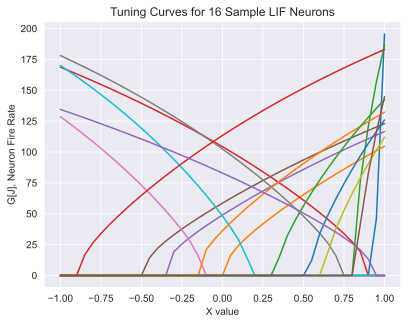

In [33]:
lif_tuning_curves, _ = create_multiple_neuron_tuning_curves(x_samples, 16, "LIF")
plot_tuning_curves(x_samples, lif_tuning_curves, "Tuning Curves for 16 Sample LIF Neurons", "X value", "G[J], Neuron Fire Rate")

**c) Impact of noise.** Generate the same four plots as in 1.1f) (adding/not adding noise to $A$, accounting/not accounting for noise when computing $\vec d$), and report the RMSE both with and without noise.

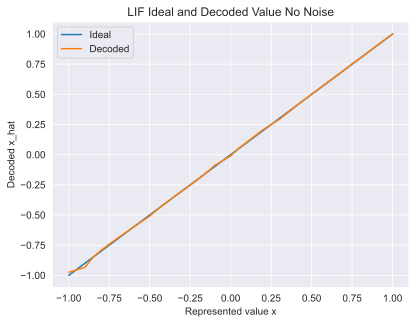

In [34]:
# plot ideal and decoded values with no noise and no noise accounted
# sigma_coeff_lif = 0.2 # assume this coefficient for sigma
A_lif = np.array([curve for curve in lif_tuning_curves])
# sigma = sigma_coeff_lif * np.max(A_lif)
D_no_reg = D_solve_no_reg(A_lif, x_samples)
x_hat_lif_1 = D_no_reg @ A_lif
plot_ideal_and_decoded_values(x_samples, x_hat_lif_1, "LIF Ideal and Decoded Value No Noise")

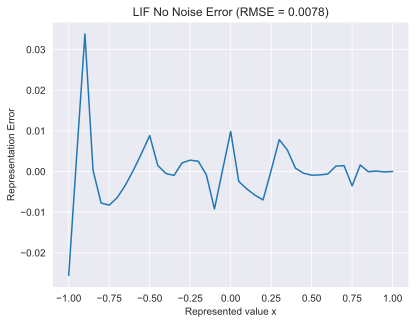

In [35]:
plot_decoded_error(x_samples, x_hat_lif_1, "LIF No Noise Error")

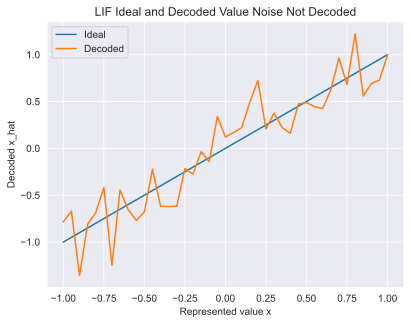

In [36]:
# plot ideal and decoded values with noise and no noise accounted
A_lif_noise = A_lif + E
x_hat_lif_2 = D_no_reg @ A_lif_noise
plot_ideal_and_decoded_values(x_samples, x_hat_lif_2, "LIF Ideal and Decoded Value Noise Not Decoded")


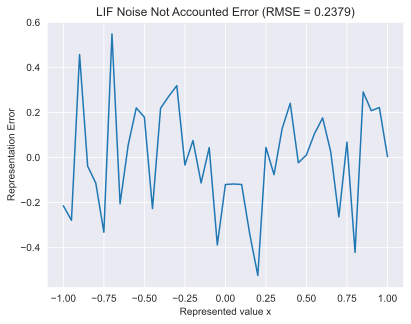

In [37]:
plot_decoded_error(x_samples, x_hat_lif_2, "LIF Noise Not Accounted Error")

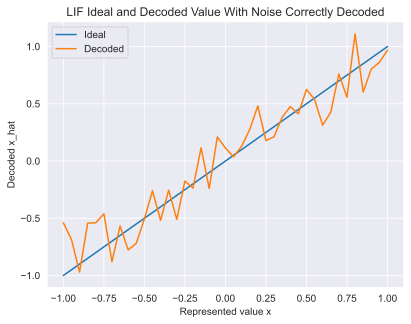

In [38]:
# plot ideal and decoded values with noise and noise accounted
sigma_coeff_lif = 0.2 # assume this coefficient for sigma
sigma = sigma_coeff_lif * np.max(A_lif)
D_reg = D_solve_reg(A_lif, x_samples, sigma)
x_hat_lif_3 = D_reg @ A_lif_noise
plot_ideal_and_decoded_values(x_samples, x_hat_lif_3, "LIF Ideal and Decoded Value With Noise Correctly Decoded")

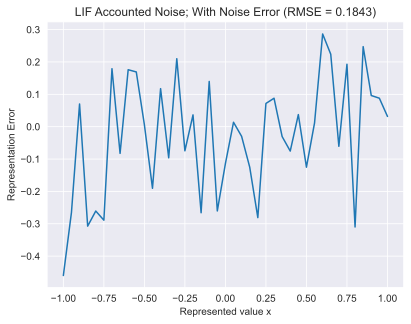

In [39]:
plot_decoded_error(x_samples, x_hat_lif_3, "LIF Accounted Noise; With Noise Error")

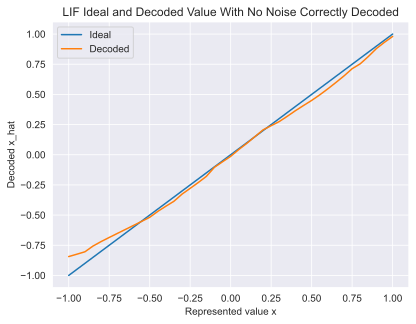

In [40]:
# plot ideal and decoded values with no noise and noise accounted
x_hat_lif_4 = D_reg @ A_lif
plot_ideal_and_decoded_values(x_samples, x_hat_lif_4, "LIF Ideal and Decoded Value With No Noise Correctly Decoded")

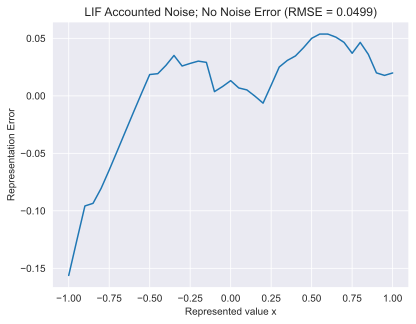

In [41]:
plot_decoded_error(x_samples, x_hat_lif_4, "LIF Accounted Noise; No Noise Error")

# 2. Reperesentation of Vectors

## 2.1 Vector tuning curves

**a) Plotting 2D tuning curves.** Plot the tuning curve of an LIF neuron whose 2D preferred direction vector is at an angle of $\theta=-\pi/4$, has an $x$-intercept at the origin $(0,0)$, and has a maximum firing rate of $100 \mathrm{Hz}$.

In [42]:
lif_2d_neuron = LIFNeuron2D(a_max_range=[100, 100], zeta_range=[0, 0], tau_ref_ms=2, tau_rc_ms=20, angle=-np.pi/4)

In [43]:
y_samples = np.linspace(-1, 1, 41)
# use this to pass to my neuron
x_samples_2d = np.array([[x_sample, y_sample] for x_sample in x_samples for y_sample in y_samples]).T
x_samples_2d.shape

(2, 1681)

In [44]:
# use this for plotting
x_mesh, y_mesh = np.meshgrid(x_samples, y_samples)
x_mesh.shape, y_mesh.shape

((41, 41), (41, 41))

In [45]:
lif_2d_tuning_curve = lif_2d_neuron.compute_tuning_curve(x_samples_2d)
lif_2d_tuning_curve.shape

(1681,)

In [46]:
lif_2d_tuning_curve_reshaped = lif_2d_tuning_curve.reshape(x_mesh.shape)
lif_2d_tuning_curve_reshaped.shape

(41, 41)

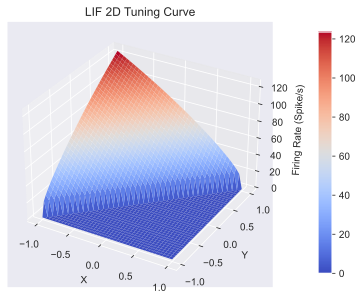

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot using scatter or plot_trisurf
# You can use plot_trisurf for unstructured data or plot_surface for structured grid
lif_2d_plot = ax.plot_surface(X = x_mesh, Y = y_mesh, Z = lif_2d_tuning_curve_reshaped, cmap=cm.coolwarm, linewidth=0)
ax.set_title("LIF 2D Tuning Curve")

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Firing Rate (Spike/s)')

cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
# Add a color bar which maps values to colors.
fig.colorbar(lif_2d_plot, cax=cbar_ax, shrink=0.5, aspect=5)

**b) Plotting the 2D tuning curve along the unit circle.** Plot the tuning curve for the same neuron as in a), but only considering the points around the unit circle, i.e., sample the activation for different angles $\theta$. Fit a curve of the form $c_1 \cos(c_2\theta+c_3)+c_4$ to the tuning curve and plot it as well.

In [48]:
# plot tuning curve again, but only consider points along unit circle
unit_circle_angles = np.linspace(-np.pi, np.pi, 100)
unit_circle_angles.shape

(100,)

In [49]:
unit_circle_points = np.stack([np.cos(unit_circle_angles), np.sin(unit_circle_angles)], axis=1).T
# for point in unit_circle_points:
#     if np.abs(np.linalg.norm(point) - 1) > 0.01:
#         print(f"{point} failed check")

In [50]:
lif_2d_tuning_curve_unit_circle = lif_2d_neuron.compute_tuning_curve(unit_circle_points)
lif_2d_tuning_curve_unit_circle.shape

(100,)

In [51]:
# fit a curve to the tuning curve and plot
def tuning_curve_model(theta, c1, c2, c3, c4):
    return c1 * np.cos(c2 * theta + c3) + c4

popt, _ = opt.curve_fit(tuning_curve_model, unit_circle_angles, lif_2d_tuning_curve_unit_circle)
# spread the optimal values
c1_opt, c2_opt, c3_opt, c4_opt = popt
print(f"Optimal parameters: c1={c1_opt}, c2={c2_opt}, c3={c3_opt}, c4={c4_opt}")

tuning_curve_fit = tuning_curve_model(unit_circle_angles, *popt)

Optimal parameters: c1=56.07672583167429, c2=1.1414170262188632, c3=-5.418062623238366, c4=40.445572845213825


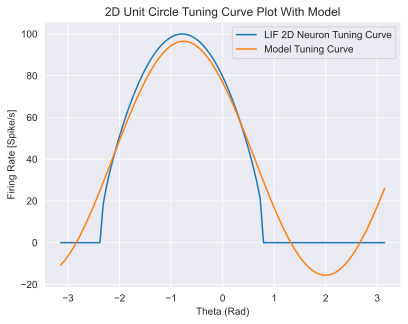

In [52]:
ax = sns.lineplot(x = unit_circle_angles, y = lif_2d_tuning_curve_unit_circle, label = "LIF 2D Neuron Tuning Curve")
sns.lineplot(x = unit_circle_angles, y = tuning_curve_fit, label = "Model Tuning Curve")
ax.set_title("2D Unit Circle Tuning Curve Plot With Model")
ax.set_xlabel("Theta (Rad)")
ax.set_ylabel("Firing Rate [Spike/s]")
plt.legend()

**c) Discussion.** What makes a cosine a good choice for the curve fit in 2.1b? Why does it differ from the ideal curve?

Cosine is a good choice for the curve fit in 2.1b because it closely follows the firing rate as a function of the angle. This, to some extent makes sense since we are sampling the points along the unit circle, so the change in firing rate is due to the change in angle along the unit circle. We expect a spike near the preffered angle, with decreasing fire rates at either side of the angle - as well as 0 firing rates as the angle moves away. A cosine curve is able to model the change in angle from the preffered direction. It differs, however, partially in following the firing rate curve, but more particularly in the biological plausbility. The model has negative values, which are not possible for the ideal curve (no negative firing rate possible). It also cycles slightly early, since the ideal curve is not periodic around the unit circle. 

## 2.2 Vector representation

**a) Choosing encoding vectors.** Generate a set of $100$ random unit vectors uniformly distributed around the unit circle. These will be the encoders $\vec e$ for $100$ neurons. Plot these vectors with a quiver or line plot (i.e., not just points, but lines/arrows to the points).

In [53]:
unit_circle_angles.shape

(100,)

In [54]:
lif2d_neuron_population, lif_2d_neurons = create_multiple_neuron_tuning_curves(x_samples_2d, 100, "LIF2D", angles=unit_circle_angles)
len(lif_2d_neurons)

100

In [55]:
lif_2d_encoders = []

for neuron in lif_2d_neurons:
    lif_2d_encoders.append(neuron.e)

lif_2d_encoders = np.array(lif_2d_encoders)
lif_2d_encoders.shape

(100, 2)

In [56]:
def quiver_plot(data, title, xlabel, ylabel, ax_lim = None, c = "black", width = 0.002, label=None):
    # assume plots come from the origin
    X = np.zeros(len(data))
    Y = np.zeros(len(data)) 
    U = data[:, 0]
    V = data [:, 1]
    plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, width=width, color=c, label=label)
    if ax_lim != None:
        plt.xlim(*ax_lim)  # Set limits for the plot
        plt.ylim(*ax_lim)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

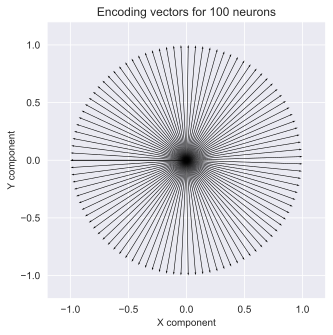

In [57]:
plt.figure(figsize=(5, 5))
quiver_plot(lif_2d_encoders, "Encoding vectors for 100 neurons", "X component", "Y component", ax_lim = (-1.2, 1.2))

**b) Computing the identity decoder.** Use LIF neurons with the same properties as in question 1.3. When computing the decoders, take into account noise with $\sigma = 0.2\max(A)$. Plot the decoders in the same way you plotted the encoders.

In [58]:
len(x_samples_2d), x_samples_2d.shape

(2, (2, 1681))

In [59]:
A = np.array([curve for curve in lif2d_neuron_population])
A.shape

(100, 1681)

In [60]:
# Note: Lif neurons with the same property as in 1.3 were already created above
sigma = 0.2 * np.max(A)

In [61]:
D_reg = D_solve_reg(A, x_samples_2d, sigma).T
D_reg.shape

(2, 100)

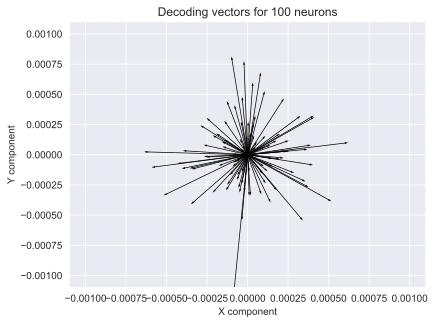

In [62]:
quiver_plot(D_reg.T, "Decoding vectors for 100 neurons", "X component", "Y component", ax_lim=(-0.0011, 0.0011))

**c) Discussion.** How do these decoding vectors compare to the encoding vectors?

The decoding vectors are much smaller magnitude than the encoding vectors, and are also not distributed uniformally around the unit circle. This in general makes sense because the encoding and decoding vectors have different purposes. The encoding vectors are preferred direction vectors for the neurons - so they must be unit vectors (magnitude 1) distributed around the unit circle to be able to capture different possible values being represented. However, the decoding vectors are attempting to minimize the squared error between the encoded tuning curves and the values themselves. Thus, this is a different as the purpose of the decoders it to take a representation in a different, more abstract activation space back to the space of normal values - which end up being vectors of much smaller magnitudes and varying angles (by least square minimization).

**d) Testing the decoder.** Generate 20 random $\vec x$ values throughout the unit circle (i.e.,~with different directions and radiuses). For each $\vec x$ value, determine the neural activity $a_i$ for each of the 100 neurons. Now decode these values (i.e. compute $\hat{x} = D \vec a$) using the decoders from part b). Plot the original and decoded values on the same graph in different colours, and compute the RMSE.

In [63]:
# generate 20 random x values throughout the unit circle
num_vectors = 20
random_x_mag = np.random.uniform(low=0.0, high=1.0, size=num_vectors)
random_x_angle = np.random.uniform(low=-np.pi, high=np.pi, size=num_vectors)
random_x_vectors = np.column_stack([random_x_mag * np.cos(random_x_angle), random_x_mag * np.sin(random_x_angle)]).T
random_x_vectors.shape

(2, 20)

In [64]:
# NOTE: we run this twice since the first run results in a strange configuration of vectors
# generate 20 random x values throughout the unit circle
num_vectors = 20
random_x_mag = np.random.uniform(low=0.0, high=1.0, size=num_vectors)
random_x_angle = np.random.uniform(low=-np.pi, high=np.pi, size=num_vectors)
random_x_vectors = np.column_stack([random_x_mag * np.cos(random_x_angle), random_x_mag * np.sin(random_x_angle)]).T
random_x_vectors.shape

(2, 20)

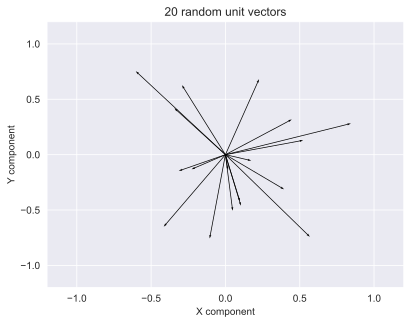

In [65]:
# note that the quiver plot expexts the transpose of the default X shape
quiver_plot(random_x_vectors.T, "20 random unit vectors", "X component", "Y component", ax_lim=(-1.2, 1.2))

In [66]:
# for the 100 2d lif neural population, compute the tuning curves and make the A matrix
A_2d_random_vects = np.array([neuron.compute_tuning_curve(random_x_vectors) for neuron in lif_2d_neurons])
A_2d_random_vects.shape

(100, 20)

In [67]:
# use the previous computed decoders for the neural population to compute the signals
x_hat = D_reg @ A_2d_random_vects
x_hat.shape

(2, 20)

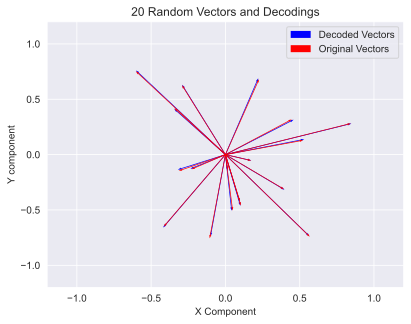

In [68]:
# plot both original and decoded values on the same graph
quiver_plot(x_hat.T, "", "", "", c = "blue", ax_lim=(-1.2, 1.2), label="Decoded Vectors")
quiver_plot(random_x_vectors.T, "20 Random Vectors and Decodings", "X Component", "Y component", c = "red", ax_lim=(-1.2, 1.2), label="Original Vectors")
plt.legend()


In [69]:
def vector_rmse(x, x_hat, debug=False):
    err = x - x_hat
    if debug:
        print(f"Errors: {err}")
    err_squared = np.square(err)
    err_squared_flat = err_squared.flatten()
    return np.sqrt(np.mean(err_squared_flat))

In [70]:
# compute the RMSE of the 2D vectors
# rmse = np.sqrt(np.mean(np.square(x_hat - random_x_vectors)))
print(f"The RMSE for the 20 generated random vectors and their decoded values is {vector_rmse(random_x_vectors.T, x_hat.T)}")

The RMSE for the 20 generated random vectors and their decoded values is 0.006055312844152265


**e) Using encoders as decoders.** Repeat part d) but use the *encoders* as decoders. This is what Georgopoulos used in his original approach to decoding information from populations of neurons. Plot the decoded values and compute the RMSE. In addition, recompute the RMSE in both cases, but ignore the magnitude of the decoded vectors by normalizing before computing the RMSE.

In [71]:
D_reg.shape, lif_2d_encoders.shape, A_2d_random_vects.shape

((2, 100), (100, 2), (100, 20))

In [72]:
x_hat_georg = lif_2d_encoders.T @ A_2d_random_vects
x_hat_georg.shape

(2, 20)

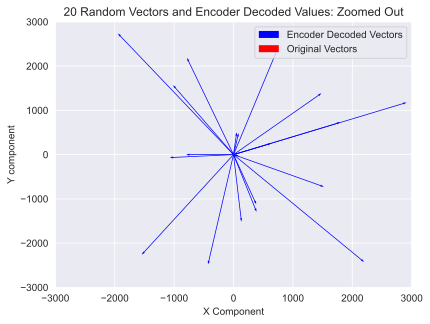

In [73]:
# plot both original and georgopoulos decoded values on the same graph
quiver_plot(x_hat_georg.T, "", "", "", c = "blue", ax_lim=(-3000, 3000), label="Encoder Decoded Vectors")
quiver_plot(random_x_vectors.T, "20 Random Vectors and Encoder Decoded Values: Zoomed Out", "X Component", "Y component", c = "red", ax_lim=(-3000, 3000), label="Original Vectors")
plt.legend()

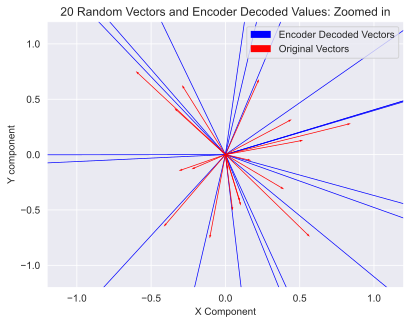

In [74]:
quiver_plot(x_hat_georg.T, "", "", "", c = "blue", ax_lim=(-1.2, 1.2), label="Encoder Decoded Vectors")
quiver_plot(random_x_vectors.T, "20 Random Vectors and Encoder Decoded Values: Zoomed in", "X Component", "Y component", c = "red", ax_lim=(-1.2, 1.2), label="Original Vectors")
plt.legend()

In [75]:
# rmse_georg = np.sqrt(np.mean(np.square(x_hat_georg - random_x_vectors)))
print(f"The RMSE for the 20 generated random vectors and Georgopoulos' method for decoding: {vector_rmse(random_x_vectors.T, x_hat_georg.T)}")

The RMSE for the 20 generated random vectors and Georgopoulos' method for decoding: 1412.4761331719503


In [76]:
# now, compute the noramlized RMSE values
x_hat_georg.shape, x_hat.shape, random_x_vectors.shape

((2, 20), (2, 20), (2, 20))

In [77]:
def normalize_vectors(v):
    norms = np.linalg.norm(v , axis=1, keepdims=True)
    return v / norms

In [78]:
x_hat_norm, x_hat_georg_norm, random_x_vectors_norm = normalize_vectors(x_hat.T), normalize_vectors(x_hat_georg.T), normalize_vectors(random_x_vectors.T)

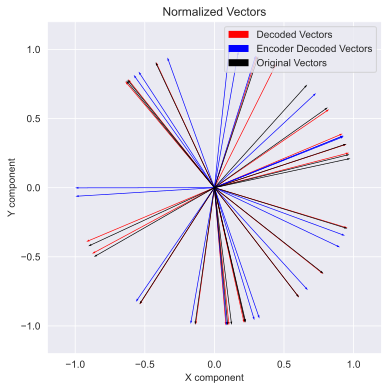

In [79]:
plt.figure(figsize=(6, 6))
quiver_plot(x_hat_norm, "", "", "", ax_lim=(-1.2, 1.2), c="red", label="Decoded Vectors")
quiver_plot(x_hat_georg_norm, "", "", "", ax_lim=(-1.2, 1.2), c="blue", label="Encoder Decoded Vectors")
quiver_plot(random_x_vectors_norm, "Normalized Vectors", "X component", "Y component", ax_lim=(-1.2, 1.2), label="Original Vectors")
plt.legend()

In [80]:
def angular_rmse(x, x_hat, mean_func = np.mean, debug=False):
    x_norm = normalize_vectors(x)
    x_hat_norm = normalize_vectors(x_hat)
    dot_prod = np.sum(x_norm * x_hat_norm, axis=1)
    # arccos of the dot product of 2 unit vectors yields the angle
    angular_error = np.arccos(dot_prod)
    # output the angular RMSE for each vector
    if debug:
        print(f"Angular error for pairs of vectors: {angular_error}")
    square_diff = np.square(angular_error)
    square_diff_flat = square_diff.flatten()
    return np.sqrt(mean_func(square_diff_flat))

In [81]:
print(f"The angular RMSE (mean) for the 20 generated random vectors and their normalized decoded values is {angular_rmse(random_x_vectors.T, x_hat.T)}")

print(f"The angular RMSE (mean) for the 20 generated random vectors and normalized Georgopoulos' method for decoding: {angular_rmse(random_x_vectors.T, x_hat_georg.T, debug=True)}")

The angular RMSE (mean) for the 20 generated random vectors and their normalized decoded values is 0.07452679559626803
Angular error for pairs of vectors: [0.09166203 0.05677218 0.00809477 0.10242071 1.18481855 0.52278692
 0.67861829 0.06228377 0.6233579  0.10985489 0.08254788 1.09260818
 0.1336356  0.37438881 0.22448729 0.03224125 0.06900954 0.03142692
 0.01948791 0.14265011]
The angular RMSE (mean) for the 20 generated random vectors and normalized Georgopoulos' method for decoding: 0.4472623384238568


**f) Discussion.** When computing the RMSE on the normalized vectors, using the encoders as decoders should result in a larger, yet still surprisingly small error. Thinking about random unit vectors in high dimensional spaces, why is this the case? What are the relative merits of these two approaches to decoding?

Using encoders are decoders may result in small angular errors since an encoder may be able to decode the preffered direction of a certain vector. We are taking an encoded vector in the activation space, which as seen in 2b has a preffered direction. To return back to a decoded value, this activation space encoded value may be decoded by having a vector which is angled in a similar manner. In this case, our encoding vectors sweep the angular space densly from 0 -> 2pi, so there is a large chance of an encoding vector matching with the preffered direction of a tuning curve. The resulting decoding then has high angular accuracy. 

Georgopoulos' approach has merit in the fact that it is simple and intuative; it can provide good direction estimate, however, is unable to recostruct magnitudes (more efficient, less accurate). The NEF has merit in the fact that it can compute optimal decoders, which are able to retain both magnitudes and directions. 